# Homework: Week 6

## Dataset

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-20 13:16:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv.4’

housing.csv.4       100%[===================>]   1,36M  --.-KB/s    in 0,1s    

2023-10-20 13:16:01 (11,2 MB/s) - ‘housing.csv.4’ saved [1423529/1423529]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_raw = pd.read_csv('./housing.csv')
df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Preparing the dataset

In [4]:
#display(df.ocean_proximity.unique())

# First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`
df = df_raw[df_raw.ocean_proximity.isin(['<1H OCEAN', 'INLAND'])]

#display(df.ocean_proximity.unique())

In [5]:
#display(df.isnull().sum())

df.fillna(0, inplace=True)

#display(df.isnull().sum())

/var/folders/r6/4c778b992hv25hqynjsb5f380000gn/T/ipykernel_13641/886748694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [6]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)


df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [7]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

In [10]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [11]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
score = rmse(y_val, y_pred)

print(score)

0.24472888684076877


## Question 3

In [12]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n,
                                random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = rmse(y_val, y_pred)

    scores.append((n, score))

columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)    

In [13]:
df_scores

,n_estimators,rmse
0,10,0.244729
1,20,0.238247
2,30,0.236230
3,40,0.234584
4,50,0.234490
5,60,0.234146
6,70,0.234152
7,80,0.234313
8,90,0.234303
9,100,0.234156


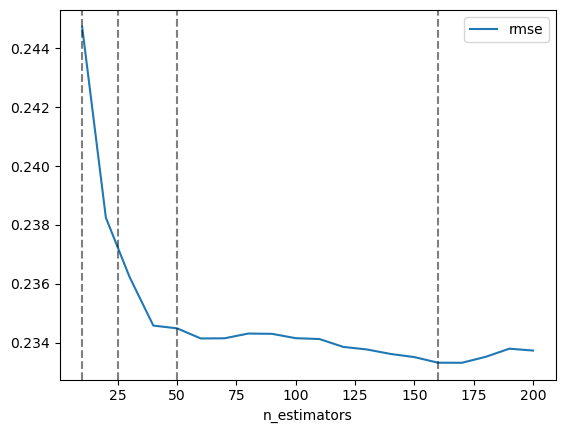

In [14]:
ans_list = [10, 25, 50, 160]

fig, ax = plt.subplots()
df_scores.plot(x='n_estimators', y='rmse', ax=ax)

for ans in ans_list:
    ax.axvline(x=ans, ls='dashed', color='k', alpha=0.5)

## Question 4

In [15]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = rmse(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)    

df_scores        

,max_depth,n_estimators,rmse
0,10,10,0.250510
1,10,20,0.247259
2,10,30,0.246262
3,10,40,0.245086
4,10,50,0.245621
...,...,...,...
75,25,160,0.233401
76,25,170,0.233398
77,25,180,0.233630
78,25,190,0.233886


<Axes: xlabel='None-max_depth', ylabel='n_estimators'>

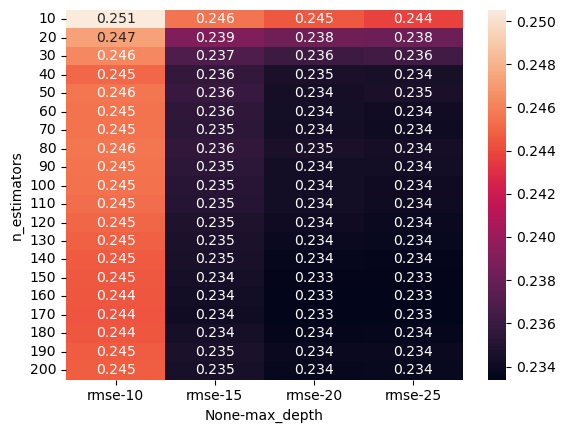

In [16]:
import seaborn as sns

df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

## Question 5

In [17]:
rf = RandomForestRegressor(n_estimators=10,
                                max_depth=20,
                                random_state=1,
                                n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [19]:
feature_names = dv.get_feature_names_out()

In [20]:
forest_importances = pd.Series(importances, index=feature_names)

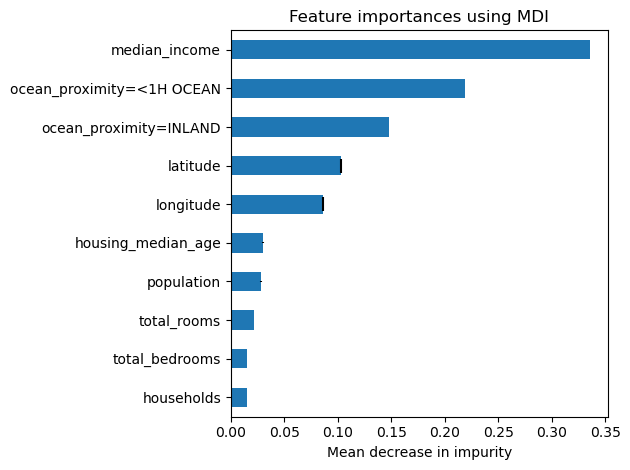

In [21]:
fig, ax = plt.subplots()
forest_importances.sort_values().plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()


## Question 6

In [22]:
!pip install xgboost

In [23]:
import xgboost as xgb

In [24]:
features = [i.replace("=<", "_").replace("=","_") for i in dv.get_feature_names_out().tolist()]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [25]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [26]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [27]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

,num_iter,train_rmse,val_rmse
16,80,0.12192,0.22886
17,85,0.11854,0.22888
18,90,0.11496,0.22861
19,95,0.11211,0.22908
20,99,0.10989,0.22862


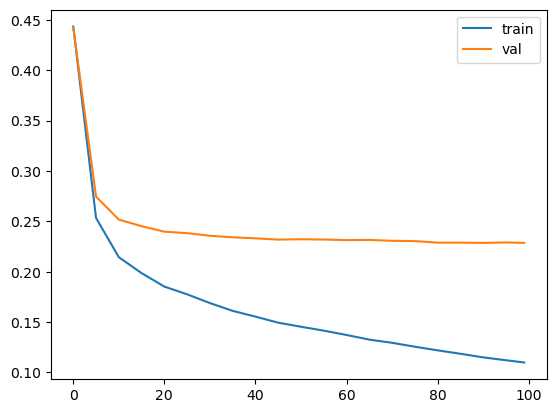

In [28]:
df_score = parse_xgb_output(output)

display(df_score.tail())

plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()

In [29]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

,num_iter,train_rmse,val_rmse
16,80,0.17242,0.23453
17,85,0.17014,0.23404
18,90,0.16797,0.23332
19,95,0.16562,0.23276
20,99,0.16323,0.23209


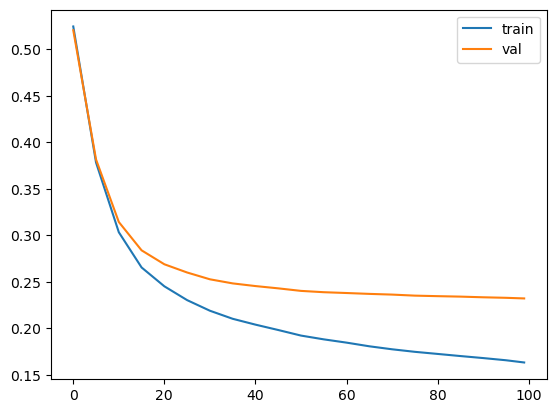

In [30]:
df_score = parse_xgb_output(output)

display(df_score.tail())

plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()